In [207]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import poisson
import pickle


%matplotlib inline

In [88]:
raw_data = pd.read_csv("fwww.csv")

In [89]:
raw_data.head(5)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,corners,event,fouls,game_date,game_id,goals,home,offsides,opponent,possession,red_cards,saves,shots,shots_on_goal,team,venue,yellow_cards
0,0,NaN,NaN,NaN,Women's International Friendly,NaN,2008-07-02 16:00:00,244655,0.0,1.0,NaN,United States,NaN,NaN,NaN,NaN,NaN,Norway,NaN,NaN
1,1,NaN,NaN,NaN,Women's International Friendly,NaN,2008-07-02 16:00:00,244655,4.0,0.0,NaN,Norway,NaN,NaN,NaN,NaN,NaN,United States,NaN,NaN
2,2,NaN,NaN,NaN,Women's International Friendly,NaN,2008-07-05 07:00:00,247584,0.0,1.0,NaN,United States,NaN,NaN,NaN,NaN,NaN,Sweden,NaN,NaN
3,3,NaN,NaN,NaN,Women's International Friendly,NaN,2008-07-05 07:00:00,247584,1.0,0.0,NaN,Sweden,NaN,NaN,NaN,NaN,NaN,United States,NaN,NaN
4,4,NaN,NaN,NaN,Women's International Friendly,NaN,2008-07-13 07:00:00,247585,0.0,0.0,NaN,United States,NaN,NaN,NaN,NaN,NaN,Brazil,NaN,NaN


In [4]:
raw_data.isna().sum()

Unnamed: 0          0
Unnamed: 0.1        8
Unnamed: 0.1.1     12
corners           276
event               0
fouls             276
game_date           0
game_id             0
goals               2
offsides          276
possession        276
red_cards         276
saves             276
shots             276
shots_on_goal     276
team                0
venue               0
yellow_cards      276
dtype: int64

In [5]:
drop_teams=["Bolivia","Cuba","Czech Republic Women","Great Britain Women","Panama","Vietnam Women"]

for teams in drop_teams:
    data=data[data.team != teams]

NameError: name 'data' is not defined

In [227]:
columns_w_null=["goals","fouls","yellow_cards","red_cards","offsides","corners","saves","possession","shots",
                "shots_on_goal"]
for column in columns_w_null:
    data[column] = data.groupby("team")[column].transform(lambda x: x.fillna(x.median()))

In [228]:
data.isna().sum()

Unnamed: 0              0
game_date               0
game_id                 0
event                   0
team                    0
venue                   0
goals                   0
fouls                   0
yellow_cards            0
red_cards               0
offsides                0
corners                 0
saves                   0
possession              0
shots                   0
shots_on_goal           0
on_target_percent       0
finishes_per_attempt    0
finished_per_target     0
dtype: int64

In [90]:
def clean_data(df):
    
    drop_teams=["Bolivia","Cuba","Czech Republic Women","Great Britain Women","Panama","Vietnam Women"]

    for teams in drop_teams:
        df=df[df.team != teams]
        
    columns_w_null=["goals","fouls","yellow_cards","red_cards","offsides","corners","saves","possession","shots",
                "shots_on_goal"]
    
    for column in columns_w_null:
        df[column] = df.groupby("team")[column].transform(lambda x: x.fillna(x.median()))
     
    df["on_target_percent"]=df["shots_on_goal"]/df["shots"]
    
    df["finishes_per_attempt"]=df["goals"]/df["shots"]
    df["finished_per_target"]=df["goals"]/df["shots_on_goal"]
        
    df.replace([np.inf, -np.inf], float(0.00),inplace=True)
    df.fillna(float(0.00),inplace=True)
    
    return df


In [91]:
data=clean_data(raw_data)

In [92]:
data.drop(["Unnamed: 0","Unnamed: 0.1","Unnamed: 0.1.1"],axis=1,inplace=True)

In [93]:
data.describe()

,corners,fouls,game_id,goals,home,offsides,possession,red_cards,saves,shots,shots_on_goal,yellow_cards,on_target_percent,finishes_per_attempt,finished_per_target
count,2098.000000,2098.000000,2098.000000,2098.00000,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000
mean,4.453765,9.648713,452982.703527,1.50143,0.249285,2.195901,0.491692,0.017159,2.948999,11.783603,4.259771,0.860820,0.367796,0.144104,0.345833
std,3.192334,4.012059,80405.045376,1.71260,0.432702,1.718089,0.135913,0.128047,2.214374,6.987804,2.991797,0.957081,0.187126,0.205140,0.419332
min,0.000000,0.000000,241579.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,7.000000,420059.000000,0.00000,0.000000,1.000000,0.430000,0.000000,2.000000,7.000000,2.000000,0.000000,0.272727,0.000000,0.000000
50%,4.000000,10.000000,477662.000000,1.00000,0.000000,2.000000,0.490000,0.000000,3.000000,11.000000,4.000000,1.000000,0.333333,0.095238,0.272727
75%,6.000000,12.000000,527467.000000,2.00000,0.000000,3.000000,0.560000,0.000000,4.000000,16.000000,6.000000,1.000000,0.437500,0.200000,0.500000
max,19.000000,29.000000,540313.000000,13.00000,1.000000,11.000000,1.000000,1.000000,14.000000,40.000000,21.000000,6.000000,1.000000,2.333333,7.000000


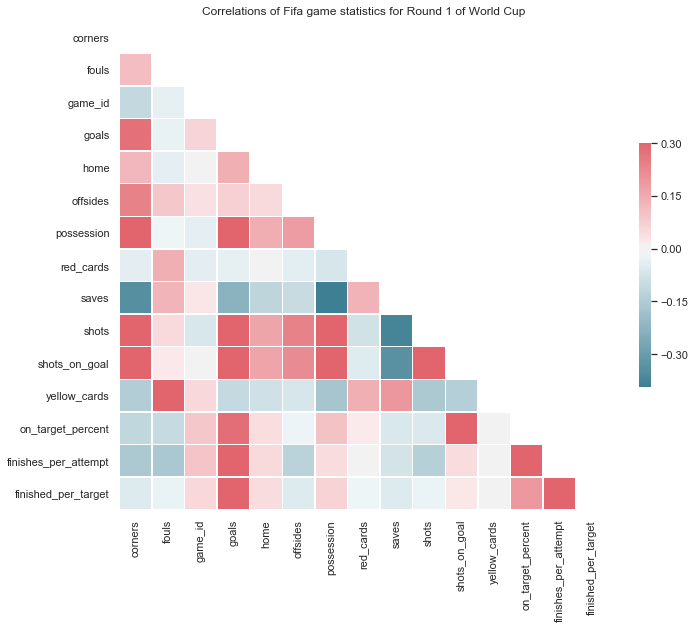

In [94]:
#graph correlations
sns.set(style="white")

d=data

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlations of Fifa game statistics for Round 1 of World Cup" )
plt.savefig("Round_1_Correlation_graph.png")

In [11]:
fwww=data[data["event"].str.contains("2019 FIFA Women's World Cup")]

In [12]:
fwww.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 939
Data columns (total 18 columns):
corners                 72 non-null float64
event                   72 non-null object
fouls                   72 non-null float64
game_date               72 non-null object
game_id                 72 non-null int64
goals                   72 non-null float64
offsides                72 non-null float64
possession              72 non-null float64
red_cards               72 non-null float64
saves                   72 non-null float64
shots                   72 non-null float64
shots_on_goal           72 non-null float64
team                    72 non-null object
venue                   72 non-null object
yellow_cards            72 non-null float64
on_target_percent       72 non-null float64
finishes_per_attempt    72 non-null float64
finished_per_target     72 non-null float64
dtypes: float64(13), int64(1), object(4)
memory usage: 10.7+ KB


In [13]:
percents=('possession',
 'on_target_percent',
 'finishes_per_attempt',
 'finished_per_target')

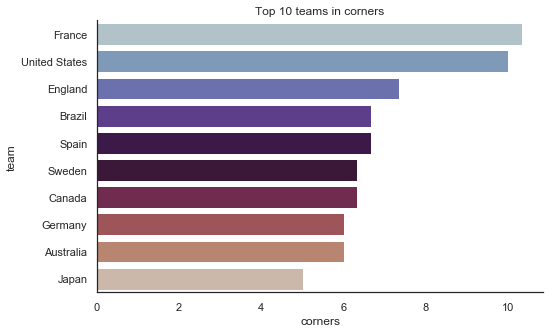

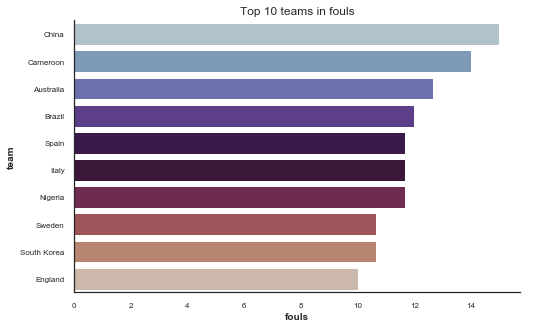

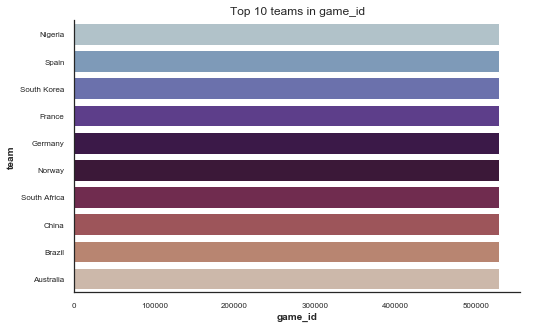

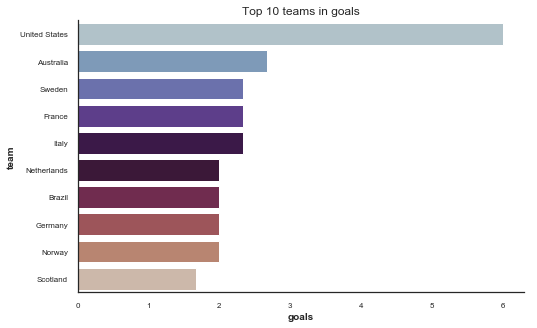

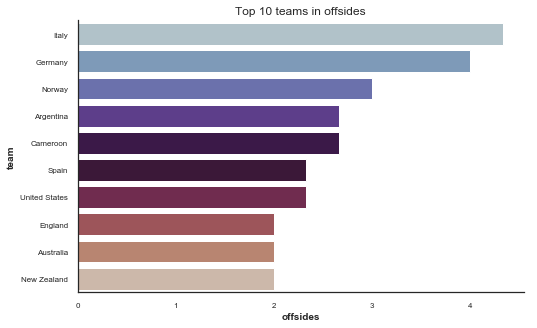

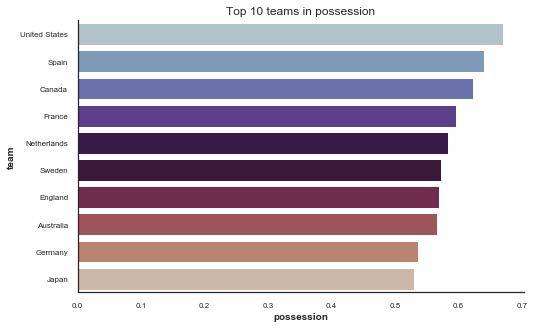

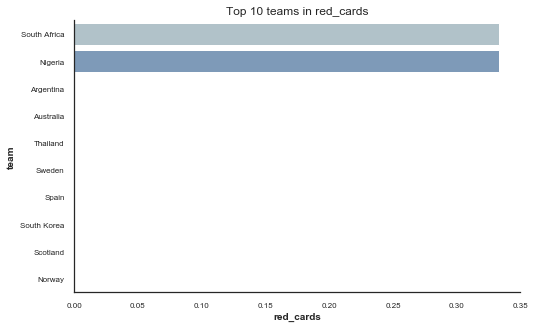

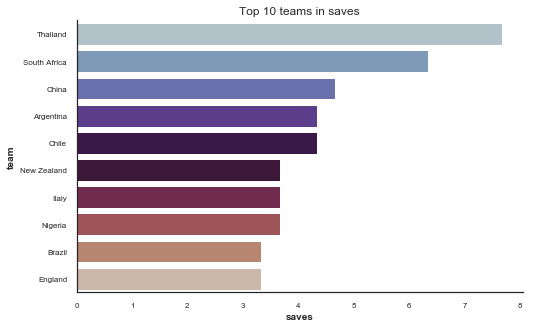

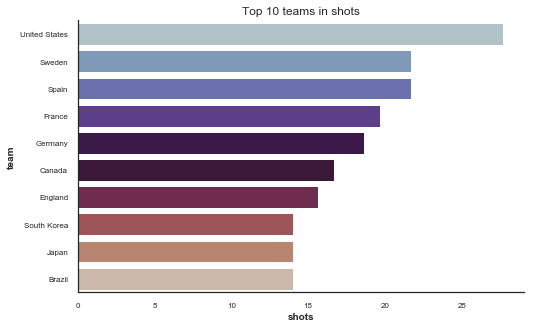

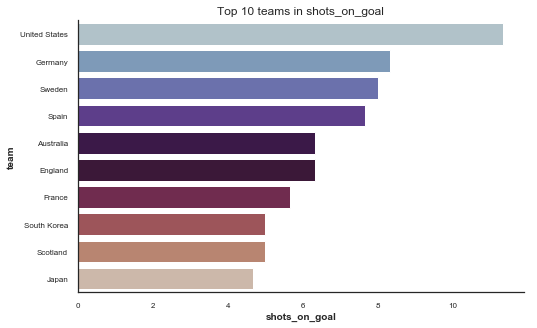

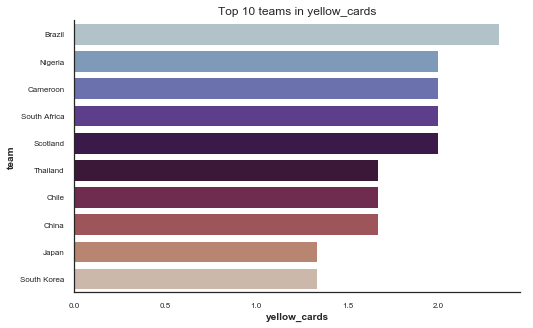

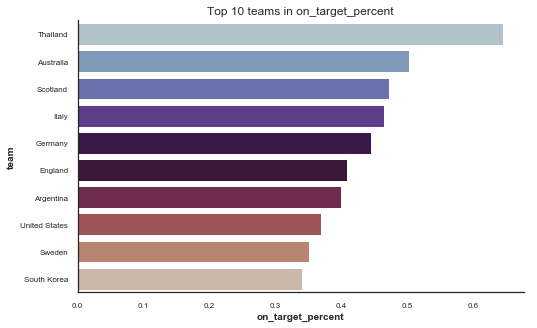

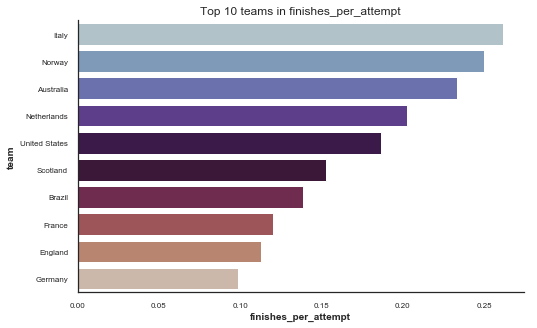

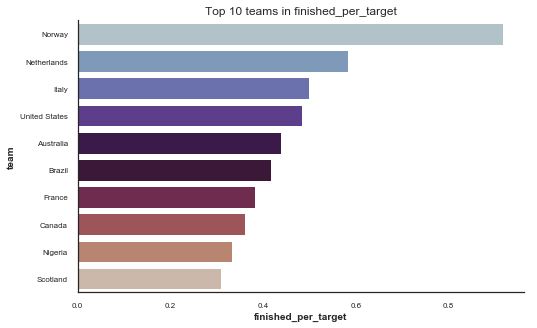

In [14]:
for variable in fwww.groupby("team").mean():
    f, ax = plt.subplots(figsize=(8, 5))
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    plt.rcParams['figure.titlesize'] = 10
    sns.barplot(fwww.groupby("team").mean().sort_values(variable,axis=0,ascending=False)[variable][:10],
                fwww.groupby("team").mean().sort_values(variable,axis=0,ascending=False).index[:10], data=fwww.groupby("team").mean(),
                palette="twilight")
    sns.despine()
    plt.title("Top 10 teams in " + variable)
    plt.savefig("Top_10_in_" + variable+".png")
    plt.show()

# Modeling Using Random Forest Regressor


In [365]:
features=data[['team','possession',
                    'on_target_percent',
                    'finishes_per_attempt',
                    'finished_per_target','corners','red_cards','fouls']]
features=pd.get_dummies(features)

In [366]:
forest = RandomForestRegressor(n_estimators=100, max_depth= 5)
forest.fit(features, data["goals"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [367]:
X_train,X_test,y_train,y_test = train_test_split(features,data["goals"],test_size=0.3,random_state=62)

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 13, 25, 37, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 21.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 13, 25, 37, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [34]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 37,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [35]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 10)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 0.3075 degrees.
Accuracy = 80.10%.
Model Performance
Average Error: 0.2951 degrees.
Accuracy = 81.14%.
Improvement of 1.29%.


In [368]:
final_model=RandomForestRegressor(bootstrap=True,
                                  max_depth=37,
                                  max_features='auto',
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=800)
final_model.fit(X_train,y_train)

filename = 'finalized_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

### Predicting Scores

In [341]:
ewm_df=data.sort_values("game_date").groupby('team').apply(lambda x: x.ewm(5).mean())

In [342]:
prediction_df=ewm_df.sort_values('game_date').drop_duplicates('team',keep='last')

In [343]:
prediction_df

,corners,event,fouls,game_date,game_id,goals,home,offsides,opponent,possession,red_cards,saves,shots,shots_on_goal,team,venue,yellow_cards,on_target_percent,finishes_per_attempt,finished_per_target
108,3.967534,"Copa Mundial Femenina 2011, Group Stage 2011",14.105784,2011-07-06 16:00:00,315164.687379,0.851430,0.278650,1.574285,Brazil,0.404952,0.000000e+00,3.000000,11.547624,4.625242,Equatorial Guinea Women,0,2.113094,0.400774,0.106429,0.212857
1291,3.762141,"Copa Mundial Femenina 2015, Group Stage 2015",15.166608,2015-06-15 20:00:00,410213.586317,1.097483,0.382843,1.957107,0,0.457253,0.000000e+00,4.945409,13.660404,6.032613,Ivory Coast Women,home,2.107763,0.453083,0.066247,0.163772
1402,0.470665,"Juegos Panamericanos 2015 – Mujeres, Primera Fase",11.411995,2015-07-15 21:30:00,422010.832806,0.951144,0.104733,0.470665,0,0.401186,4.706650e-01,7.470665,4.882660,2.000000,Ecuador,away,2.470665,0.435964,0.190229,0.475572
344,0.604396,Women's International Friendly,10.186813,2015-09-20 18:30:00,430651.604396,0.000000,0.000000,0.000000,United States,0.229780,0.000000e+00,11.208791,0.000000,0.000000,Haiti Women,0,1.000000,0.000000,0.000000,0.000000
406,1.572780,"2016 Women's Olympic Tournament, 2016 Women's ...",10.441195,2016-08-09 19:00:00,447203.215008,1.000000,0.134380,0.869920,Australia,0.334029,0.000000e+00,5.427220,5.653408,2.131585,Zimbabwe,0,1.591271,0.490432,0.249731,0.643195
585,0.278650,"2017 Women's International Friendly, Women's I...",13.295635,2017-01-20 14:00:00,474078.558160,2.246184,0.278650,0.278650,Netherlands,0.264287,0.000000e+00,9.574285,2.018491,1.165556,Romania,0,2.868415,0.314610,0.724092,2.049093
1780,1.180328,"2017 Women's International Friendly, Women's I...",7.229508,2017-04-09 08:00:00,498216.409836,0.590164,0.000000,0.409836,0,0.394098,0.000000e+00,1.590164,8.131148,2.770492,Croatia,away,1.180328,0.317064,0.053651,0.147541
1669,2.432960,"Women's European Championship, Group Stage",15.903151,2017-07-25 18:45:00,487296.713516,0.430576,0.174946,2.517197,0,0.279655,0.000000e+00,5.773245,5.217065,1.816996,Russia,home,1.516029,0.378253,0.095437,0.217508
699,7.437082,"2017 Women's International Friendly, Yongchuan...",8.814590,2017-10-21 08:00:00,458093.460461,0.778682,0.071997,2.437082,Brazil,0.484967,0.000000e+00,2.874164,11.503343,4.814590,North Korea,0,0.562918,0.414741,0.067151,0.161130
714,3.000000,"2017 Women's International Friendly, Women's I...",7.000000,2017-11-24 14:00:00,498639.000000,0.000000,0.545455,0.000000,Japan,0.250000,0.000000e+00,6.000000,3.000000,1.000000,Jordan,0,0.000000,0.333333,0.000000,0.000000


In [373]:
predicting_feat=prediction_df[['team','possession',
                    'on_target_percent',
                    'finishes_per_attempt',
                    'finished_per_target','corners','red_cards','fouls']]
predicting_feat=pd.get_dummies(predicting_feat)
predictions=np.round(final_model.predict(predicting_feat),0)
predictions

array([1., 1., 1., 0., 2., 7., 1., 1., 1., 0., 0., 2., 1., 2., 1., 0., 1.,
       2., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 3., 1., 2.,
       1., 3., 3., 1., 1., 2., 2., 1., 1., 1., 1., 2., 2., 1., 2., 1., 4.])

In [374]:
predictions=pd.DataFrame(zip(prediction_df['team'],predictions),columns=["team","predictions"])
predictions.head(5)

,team,predictions
0,Equatorial Guinea Women,1.0
1,Ivory Coast Women,1.0
2,Ecuador,1.0
3,Haiti Women,0.0
4,Zimbabwe,2.0


In [375]:
knockout_games_r1=[["Germany","Nigeria"],["Norway","Australia"],
       ["England","Cameroon"],["France","Brazil"],
       ["Spain","United States"],["Sweden","Canada"],
       ["Italy","China"],["Netherlands","Japan"]]
knockout_games_r1=pd.DataFrame(knockout_games_r1,columns=["team","opponent"])

In [376]:
knockout_games_r1.head()

,team,opponent
0,Germany,Nigeria
1,Norway,Australia
2,England,Cameroon
3,France,Brazil
4,Spain,United States


In [378]:
knockout_r1=pd.merge(knockout_games_r1, predictions,  how='inner', left_on=["team"], 
         right_on = ['team'])
knockout_r1=pd.merge(knockout_r1, predictions,  how='inner', left_on=["opponent"], 
         right_on = ['team']).drop("opponent",axis=1)

In [379]:
knockout_r1

,team_x,predictions_x,team_y,predictions_y
0,Germany,2.0,Nigeria,1.0
1,Norway,3.0,Australia,3.0
2,England,2.0,Cameroon,1.0
3,France,2.0,Brazil,1.0
4,Spain,1.0,United States,4.0
5,Sweden,2.0,Canada,2.0
6,Italy,3.0,China,1.0
7,Netherlands,2.0,Japan,2.0


In [380]:
def predictor(df):
    df["winner"] = ""
    df.columns = ["home","home_goals","away","away_goals","winner"]
    
    for index,row in df.iterrows():
        if row["home_goals"] > row["away_goals"]:
            df["winner"][index] = df["home"][index]
        elif row["home_goals"] < row["away_goals"]:
            df["winner"][index] = df["away"][index]
        else:
            df["winner"][index] = "Tie"
        print(df["winner"][index]+" ("+df["home"][index]+" "+str(df["home_goals"][index])+" : "+str(df["away_goals"][index])+" "+df["away"][index]+")")
    return df

In [381]:
predictor(knockout_r1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Germany (Germany 2.0 : 1.0 Nigeria)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Tie (Norway 3.0 : 3.0 Australia)
England (England 2.0 : 1.0 Cameroon)
France (France 2.0 : 1.0 Brazil)
United States (Spain 1.0 : 4.0 United States)
Tie (Sweden 2.0 : 2.0 Canada)
Italy (Italy 3.0 : 1.0 China)
Tie (Netherlands 2.0 : 2.0 Japan)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,home,home_goals,away,away_goals,winner
0,Germany,2.0,Nigeria,1.0,Germany
1,Norway,3.0,Australia,3.0,Tie
2,England,2.0,Cameroon,1.0,England
3,France,2.0,Brazil,1.0,France
4,Spain,1.0,United States,4.0,United States
5,Sweden,2.0,Canada,2.0,Tie
6,Italy,3.0,China,1.0,Italy
7,Netherlands,2.0,Japan,2.0,Tie


In [382]:
knockout_games_r2=[["Norway","England"],["France","United States"],
       ["Canada","Germany"],["Netherlands","Italy"]]
knockout_games_r2=pd.DataFrame(knockout_games_r2,columns=["team","opponent"])

knockout_r2=pd.merge(knockout_games_r2, predictions,  how='inner', left_on=["team"], 
         right_on = ['team'])
knockout_r2=pd.merge(knockout_r2, predictions,  how='inner', left_on=["opponent"], 
         right_on = ['team']).drop("opponent",axis=1)

predictor(knockout_r2)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Norway (Norway 3.0 : 2.0 England)
United States (France 2.0 : 4.0 United States)
Tie (Canada 2.0 : 2.0 Germany)
Italy (Netherlands 2.0 : 3.0 Italy)


,home,home_goals,away,away_goals,winner
0,Norway,3.0,England,2.0,Norway
1,France,2.0,United States,4.0,United States
2,Canada,2.0,Germany,2.0,Tie
3,Netherlands,2.0,Italy,3.0,Italy


In [383]:
knockout_games_r3=[["Norway","United States"],["Germany","Italy"]]
knockout_games_r3=pd.DataFrame(knockout_games_r3,columns=["team","opponent"])

knockout_r3=pd.merge(knockout_games_r3, predictions,  how='inner', left_on=["team"], 
         right_on = ['team'])
knockout_r3=pd.merge(knockout_r3, predictions,  how='inner', left_on=["opponent"], 
         right_on = ['team']).drop("opponent",axis=1)

predictor(knockout_r3)

United States (Norway 3.0 : 4.0 United States)
Italy (Germany 2.0 : 3.0 Italy)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,home,home_goals,away,away_goals,winner
0,Norway,3.0,United States,4.0,United States
1,Germany,2.0,Italy,3.0,Italy


In [384]:
knockout_games_r4=[["United States","Italy"],["Germany","Norway"]]
knockout_games_r4=pd.DataFrame(knockout_games_r4,columns=["team","opponent"])

knockout_r4=pd.merge(knockout_games_r4, predictions,  how='inner', left_on=["team"], 
         right_on = ['team'])
knockout_r4=pd.merge(knockout_r4, predictions,  how='inner', left_on=["opponent"], 
         right_on = ['team']).drop("opponent",axis=1)

predictor(knockout_r4)

United States (United States 4.0 : 3.0 Italy)
Norway (Germany 2.0 : 3.0 Norway)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,home,home_goals,away,away_goals,winner
0,United States,4.0,Italy,3.0,United States
1,Germany,2.0,Norway,3.0,Norway


# Modeling using Poisson Model

In [408]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

poisson_model = smf.glm(formula="goals ~ team + opponent + home + possession + on_target_percent + \
                        finishes_per_attempt + finished_per_target + corners + red_cards + fouls", 
                        data=data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2098
Model:                            GLM   Df Residuals:                     1982
Model Family:                 Poisson   Df Model:                          115
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2487.4
Date:                Fri, 21 Jun 2019   Deviance:                       1356.3
Time:                        16:24:30   Pearson chi2:                 1.61e+03
No. Iterations:                    23   Covariance Type:             nonrobust
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -2.1840      0.233     -9.359      0.000      -2.641      -1.727
team[T.Australia]                       0.2445      0.208      1.176      0.240      -0.163       0.652
team[T.Austria]                        -0.3338      0.405     -0.825      0.410      -1.127       0.460
team[T.Belgium]                        -0.5535      0.375     -1.478      0.139      -1.288       0.180
team[T.Brazil]                          0.1308      0.205      0.639      0.523      -0.271       0.532
team[T.Cameroon]                        0.0323      0.286      0.113      0.910      -0.529       0.593
team[T.Canada]                         -0.5214      0.214     -2.437      0.015      -0.941      -0.102
team[T.Catalunya Women]               -23.0830   4.89e+04     -0.000      1.000   -9.58e+04    9.57e+04
team[T.Chile]                          -0.4501      0.290     -1.554      0.120      -1.018       0.117
team[T.China]                          -0.4354      0.229     -1.902      0.057      -0.884       0.013
team[T.Colombia]                       -0.4116      0.306     -1.346      0.178      -1.011       0.188
team[T.Costa Rica]                     -0.7899      0.302     -2.613      0.009      -1.382      -0.197
team[T.Croatia]                         0.0113      0.736      0.015      0.988      -1.431       1.454
team[T.Denmark]                        -0.2480      0.332     -0.748      0.455      -0.898       0.402
team[T.Ecuador]                        -0.3414      0.458     -0.745      0.456      -1.240       0.557
team[T.England]                         0.1465      0.209      0.699      0.484      -0.264       0.557
team[T.Equatorial Guinea Women]        -0.4140      0.539     -0.769      0.442      -1.470       0.642
team[T.Finland]                        -0.1533      0.335     -0.458      0.647      -0.809       0.503
team[T.France]                          0.1466      0.205      0.715      0.475      -0.255       0.549
team[T.Germany]                         0.2611      0.210      1.245      0.213      -0.150       0.672
team[T.Ghana]                         -21.3292   2.77e+04     -0.001      0.999   -5.44e+04    5.43e+04
team[T.Haiti Women]                   -21.4981   3.44e+04     -0.001      1.000   -6.75e+04    6.74e+04
team[T.Iceland]                        -0.7851      0.337     -2.328      0.020      -1.446      -0.124
team[T.Ireland]                        -0.7915      0.737     -1.073      0.283      -2.237       0.654
team[T.Italy]                           0.0916      0.234      0.391      0.695      -0.367       0.550
team[T.Ivory Coast Women]              -0.3746      0.457     -0.820      0.412      -1.270       0.520
team[T.Jamaica]                        -0.2044      0.255     -0.800      0.424      -0.705       0.296
team[T.Japan]                           0.

In [498]:
poisson_prediction_df=prediction_df
poisson_prediction_df=poisson_prediction_df[["team","possession","on_target_percent","finishes_per_attempt",
                                             "finished_per_target","corners","red_cards","fouls"]]

In [499]:
poisson_prediction_df=poisson_prediction_df.set_index("team")
poisson_prediction_df.head(5)

,possession,on_target_percent,finishes_per_attempt,finished_per_target,corners,red_cards,fouls
team,,,,,,,
Equatorial Guinea Women,0.404952,0.400774,0.106429,0.212857,3.967534,0.000000,14.105784
Ivory Coast Women,0.457253,0.453083,0.066247,0.163772,3.762141,0.000000,15.166608
Ecuador,0.401186,0.435964,0.190229,0.475572,0.470665,0.470665,11.411995
Haiti Women,0.229780,0.000000,0.000000,0.000000,0.604396,0.000000,10.186813
Zimbabwe,0.334029,0.490432,0.249731,0.643195,1.572780,0.000000,10.441195


In [416]:
china=pd.DataFrame(poisson_prediction_df.loc["China",:])
china_data=pd.DataFrame(data={'team': 'China', 'opponent': 'Spain',
                                       'home':1},index=["China"])
china=china.transpose()
china_df=china_data.merge(china,right_index=True,left_index=True)
china_df.reset_index(drop=True)

,team,opponent,home,possession,on_target_percent,finishes_per_attempt,finished_per_target,corners,red_cards,fouls
0,China,Spain,1,0.445754,0.245915,0.118407,0.375987,3.450133,0.000517,12.699945


In [417]:
spain=pd.DataFrame(poisson_prediction_df.loc["Spain",:])
spain_data=pd.DataFrame(data={'team': 'Spain', 'opponent': 'China',
                                       'home':0},index=["Spain"])
spain=spain.transpose()
spain_df=spain_data.merge(spain,right_index=True,left_index=True)
spain_df.reset_index(drop=True)

,team,opponent,home,possession,on_target_percent,finishes_per_attempt,finished_per_target,corners,red_cards,fouls
0,Spain,China,0,0.614653,0.302818,0.052288,0.123059,5.783417,0.0,11.0497


In [547]:
poisson_model.predict(china_df)[0]

0.518625728910925

In [546]:
poisson_model.predict(spain_df)[0]

0.6167921714865015

In [420]:
def simulate_match(model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = model.predict(homeTeam)
    away_goals_avg = model.predict(awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [422]:
chi_spain=simulate_match(poisson_model, china_df, spain_df, max_goals=10)
chi_spain

array([[3.21287827e-01, 1.98167816e-01, 6.11141789e-02, 1.25649157e-02,
        1.93748541e-03, 2.39005167e-04, 2.45694193e-05, 2.16488935e-06,
        1.66910851e-07, 1.14388118e-08, 7.05536956e-10],
       [1.66628133e-01, 1.02774928e-01, 3.16953856e-02, 6.51648857e-03,
        1.00482978e-03, 1.23954229e-04, 1.27423330e-05, 1.12276732e-06,
        8.65642616e-08, 5.93246210e-09, 3.65909618e-10],
       [4.32088186e-02, 2.66508610e-02, 8.21902123e-03, 1.68980932e-03,
        2.60565289e-04, 3.21429261e-05, 3.30425087e-06, 2.91148010e-07,
        2.24472266e-08, 1.53836374e-09, 9.48850712e-11],
       [7.46973501e-03, 4.60727408e-03, 1.42086529e-03, 2.92126196e-04,
        4.50452877e-05, 5.55671617e-06, 5.71223172e-07, 5.03322829e-08,
        3.88056976e-09, 2.65945005e-10, 1.64032797e-11],
       [9.68499191e-04, 5.97362719e-04, 1.84224324e-04, 3.78760404e-05,
        5.84041130e-06, 7.20463993e-07, 7.40627585e-08, 6.52590423e-09,
        5.03140830e-10, 3.44814806e-11, 2.12679073e-

In [423]:
np.sum(np.tril(chi_spain, -1))

0.25197707548911197

In [424]:
np.sum(np.diag(chi_spain))

0.43257981845927596

In [425]:
np.sum(np.triu(chi_spain, 1))

0.31544310597019654

### Predictions

In [551]:
knockout_games_r1=[["Germany","Nigeria"],["Norway","Australia"],
       ["England","Cameroon"],["France","Brazil"],
       ["Spain","United States"],["Sweden","Canada"],
       ["Italy","China"],["Netherlands","Japan"]]
knockout_games_r1=pd.DataFrame(knockout_games_r1,columns=["home","away"])

In [552]:
def predict_a_game(home_team,away_team):
    team_1=pd.DataFrame(poisson_prediction_df.loc[home_team,:])
    team_1_data=pd.DataFrame(data={'team': home_team, 'opponent': away_team,
                                       'home':1},index=[home_team])
    team_1=team_1.transpose()
    team_1_df=team_1_data.merge(team_1,right_index=True,left_index=True)
    team_1_df.reset_index(drop=True)
    print("Expected Average Number of Goals for "+home_team)
    print(poisson_model.predict(team_1_df))
    print("\n")
                    
    team_2=pd.DataFrame(poisson_prediction_df.loc[away_team,:])
    team_2_data=pd.DataFrame(data={'team': away_team, 'opponent': home_team,
                                       'home':0},index=[away_team])
    team_2=team_2.transpose()
    team_2_df=team_2_data.merge(team_2,right_index=True,left_index=True)
    team_2_df.reset_index(drop=True)
    print("Expected Average Number of Goals for "+away_team)
    print(poisson_model.predict(team_2_df))
    print("\n")
    
    sim=simulate_match(poisson_model, team_1_df, team_2_df, max_goals=10)
    # home win
    print("Chance that "+home_team+" will win: {0:.0%}".format(np.sum(np.tril(sim, -1))))
    print("\n")
    
    #tie game
    print("Chance that there will be a tie: {0:.0%}".format(np.sum(np.diag(sim))))
    print("\n")
                           
    #away win
    print("Chance that "+away_team+" will win: {0:.0%}".format(np.sum(np.triu(sim, 1))))
    print("\n")

In [553]:
predict_a_game("Germany","Nigeria")

Expected Average Number of Goals for Germany
Germany    2.166001
dtype: float64


Expected Average Number of Goals for Nigeria
Nigeria    0.402781
dtype: float64


Chance that Germany will win: 78%


Chance that there will be a tie: 16%


Chance that Nigeria will win: 6%




In [569]:
def get_predictions(model,game_df,team_df):
    game_df["home_goals"]=""
    game_df["away_goals"]=""
    game_df["home_win"]=""
    game_df["tie"]=""
    game_df["away_win"]=""
    game_df["winner"]=""
    
    for index,row in game_df.iterrows():
        team_1=pd.DataFrame(team_df.loc[game_df["home"][index],:])
        team_1_data=pd.DataFrame(data={'team': game_df["home"][index], 'opponent': game_df["away"][index],
                                           'home':1},index=[game_df["home"][index]])
        team_1=team_1.transpose()
        team_1_df=team_1_data.merge(team_1,right_index=True,left_index=True)
        team_1_df.reset_index(drop=True)

        game_df["home_goals"][index]=model.predict(team_1_df)[0]

        team_2=pd.DataFrame(team_df.loc[game_df["away"][index],:])
        team_2_data=pd.DataFrame(data={'team': game_df["away"][index], 'opponent': game_df["home"][index],
                                           'home':0},index=[game_df["away"][index]])
        team_2=team_2.transpose()
        team_2_df=team_2_data.merge(team_2,right_index=True,left_index=True)
        team_2_df.reset_index(drop=True)
        game_df["away_goals"][index]=model.predict(team_2_df)[0]


        sim=simulate_match(model, team_1_df, team_2_df, max_goals=10)
        
        # home win
        game_df["home_win"][index]=np.sum(np.tril(sim, -1))

        #tie game
        game_df["tie"][index]=np.sum(np.diag(sim))

        #away win
        game_df["away_win"][index]=np.sum(np.triu(sim, 1))

        if row["home_win"] > row["away_win"] and row["home_win"] > row["tie"]:
            game_df["winner"][index] = game_df["home"][index]
        elif row["home_win"] < row["away_win"] and row["away_win"] > row["tie"]:
            game_df["winner"][index] = game_df["away"][index]
        else:
            game_df["winner"][index] = "Tie"
    return game_df

In [570]:
knockout_games_r1=get_predictions(poisson_model,knockout_games_r1,poisson_prediction_df)
knockout_games_r1

,home,away,home_goals,away_goals,home_win,tie,away_win,winner
0,Germany,Nigeria,2.166,0.402781,0.784618,0.159556,0.0558085,Germany
1,Norway,Australia,1.73495,2.51594,0.262246,0.188029,0.549658,Australia
2,England,Cameroon,2.35038,0.582323,0.770349,0.155214,0.0744013,England
3,France,Brazil,1.71933,0.895045,0.5685,0.237395,0.194103,France
4,Spain,United States,0.631746,2.52997,0.0716642,0.14241,0.785858,United States
5,Sweden,Canada,0.950414,0.651492,0.411598,0.346982,0.24142,Sweden
6,Italy,China,1.61756,0.614972,0.61763,0.243607,0.138762,Italy
7,Netherlands,Japan,1.89314,0.783117,0.636223,0.215508,0.148264,Netherlands


In [571]:
knockout_games_r2=[["Australia","England"],["France","United States"],
       ["Sweden","Germany"],["Netherlands","Italy"]]
knockout_games_r2=pd.DataFrame(knockout_games_r2,columns=["home","away"])

In [574]:
knockout_games_r2=get_predictions(poisson_model,knockout_games_r2,poisson_prediction_df)
knockout_games_r2

,home,away,home_goals,away_goals,home_win,tie,away_win,winner
0,Australia,England,1.8633,1.59919,0.443171,0.222254,0.33457,Australia
1,France,United States,1.46902,2.05681,0.274853,0.212873,0.512263,United States
2,Sweden,Germany,0.893019,1.59356,0.210702,0.250993,0.538303,Germany
3,Netherlands,Italy,2.07951,1.35581,0.541387,0.211085,0.247516,Netherlands


In [575]:
knockout_games_r3=[["Australia","United States"],["Germany","Netherlands"]]
knockout_games_r3=pd.DataFrame(knockout_games_r3,columns=["home","away"])

In [576]:
knockout_games_r3=get_predictions(poisson_model,knockout_games_r3,poisson_prediction_df)
knockout_games_r3

,home,away,home_goals,away_goals,home_win,tie,away_win,winner
0,Australia,United States,1.97816,3.07073,0.234891,0.164089,0.600659,United States
1,Germany,Netherlands,1.45438,1.34329,0.398946,0.252484,0.348569,Germany


In [582]:
knockout_games_r4=[["United States","Germany"],["Australia","Netherlands"]]
knockout_games_r4=pd.DataFrame(knockout_games_r4,columns=["home","away"])

In [583]:
knockout_games_r4=get_predictions(poisson_model,knockout_games_r4,poisson_prediction_df)
knockout_games_r4

,home,away,home_goals,away_goals,home_win,tie,away_win,winner
0,United States,Germany,2.85586,1.20594,0.714174,0.151955,0.133677,United States
1,Australia,Netherlands,2.09641,1.64366,0.484549,0.209796,0.305641,Australia
